In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
import PyCrystalField as cef
import scipy
from scipy.misc import derivative
import lmfit
import pandas as pd
from numba import njit

 *******************************************************
 *                PyCrystalField 2.3.9                 *
 *  Please cite  J. Appl. Cryst. (2021). 54, 356-362   * 
 *    <https://doi.org/10.1107/S160057672001554X>      *
 *******************************************************



In [145]:
import lmfit

In [159]:
temperature = 2 # in K

muB = 5.7883818012e-2  # meV/T
mu0 = np.pi*4e-7       # T*m/A
kB  = 8.617e-2         # [meV/K]
meVToCm =meVTocCmInv= 8.066 
ion = 'Er3+'

kBT = kB*temperature

Jperp = -0.2#e-3 #meV
Jz = -2.5#e-3 #meV
q= 6

In [422]:
# my fit vals
# B20 = -0.03553308
# B40 = -3.7973e-04
# B43 = -0.01424079
# B60 =  3.0728e-06
# B63 = -2.7710e-07
# B66 =  3.8956e-05 

B20 = -0.03265325 # init = -0.03559)
B40 = -0.0003849 # fixed)
B43 = -0.01393 # fixed)
B60 =  3.035e-6 #3.054e-06 # fixed) # this B60 param determined from field induced transition
B63 = -8.4011e-07 # init = -4.695e-06)
B66 =  3.3815e-05 # fixed)

g = cef.LandeGFactor(ion)
myBparams =  {'B20': B20, 'B40':B40,'B43': B43, 'B60': B60, 'B63':B63,'B66':B66}
MyErObj = cef.CFLevels.Bdict(ion,myBparams)


# neutron fit vals
B20 = -4.73e-2
B40 = -3.7037e-4
B43 = -1.44431e-2
B60 = 3.1605e-6
B63 = 6.5259e-6
B66 = 3.9314e-5

g = cef.LandeGFactor(ion)
AllenBparams =  {'B20': B20, 'B40':B40,'B43': B43, 'B60': B60, 'B63':B63,'B66':B66}
AllenErObj = cef.CFLevels.Bdict(ion,AllenBparams)

# okay, so now we rebuild with pcf built ins

In [526]:
#first do me
temperature = .05
field = [[0,0,b] for b in np.linspace(0,10,10000)]
magMe_C = np.array([MyErObj.magnetization(ion, temperature, f) for f in field]).T

magAllen_C = np.array([AllenErObj.magnetization(ion, temperature, f) for f in field]).T
field = np.array(field).T


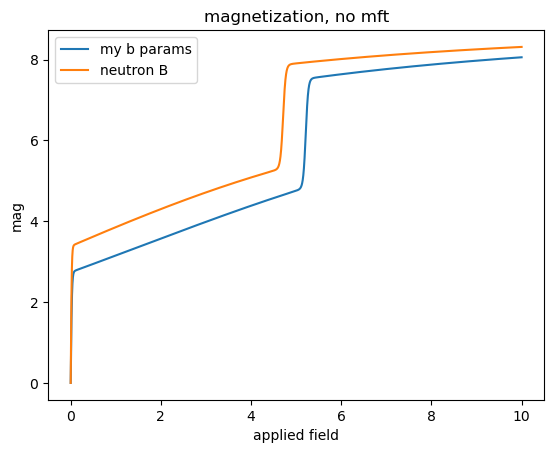

In [527]:
plt.plot(field[2], -1*magMe_C[2], label = 'my b params')
plt.plot(field[2], -1*magAllen_C[2], label = 'neutron B')
plt.title('magnetization, no mft')
plt.xlabel('applied field')
plt.ylabel('mag')
plt.legend()

In [529]:
# test mft calculation
tempFine = np.linspace(0,10,10000)
tempF = np.linspace(0,10, 1000)
mft_mZ_me_C = MolecularFieldTheory(tempF, tempFine, -1*magMe_C[2], lambC*-.2)

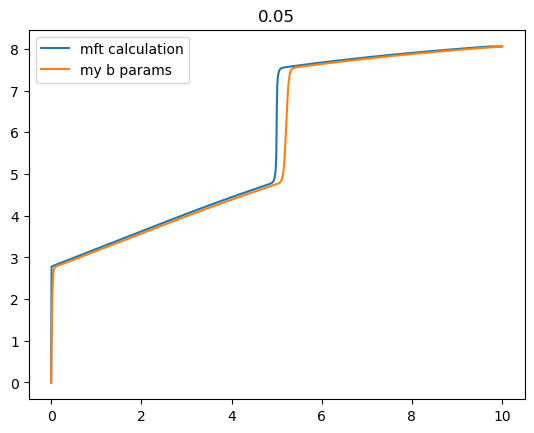

In [530]:
plt.plot(tempF, mft_mZ_me_C, label = 'mft calculation')
plt.plot(field[2], -1*magMe_C[2], label = 'my b params')
plt.title(str(temperature))
plt.legend()
# plt.xlim(0,1)

# now we do MFT
this is following the code allen sent

In [214]:
len(magAllen_C[2])


10000

Text(0, 0.5, 'magnetization')

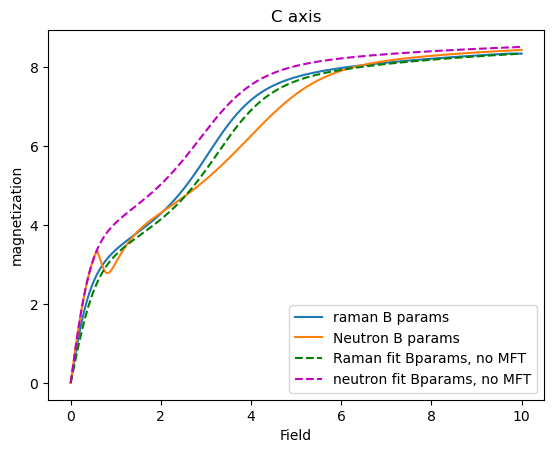

In [429]:
mme_C = magMe_C[2]
mAllen_C = magAllen_C[2]
f = np.linspace(0,10,1000)
ffine = np.linspace(0,10,len(mme_C))

gJ = cef.LandeGFactor('Er3+')
# print(gJ)
# @njit

Jperp = -0.2e-3 #meV
Jz = -2.4e-3 #meV
q= 6

def MolecularFieldTheory(H, Hth, Mth, lamb):
    '''Use mean field theory to correct magnetization
    for an exchange strength lamb. H is the number of fields to calculate,
    Hth and Mth are the theoretical single-ion magnetization curves to correct.'''
    n = 10
    # colors = plt.cm.gnuplot(np.linspace(0,1,n))
    # plt.figure()
    # plt.plot(Hth, Mth, 'r', label = 'orginal data')
    newM = np.interp(H, Hth, Mth)
    for i in range(n):
        newH = H + 6*lamb*newM/muB/(gJ)**2
        newM = np.interp(newH,Hth,Mth)
        # for testing
    #     plt.plot(newH, newM, label = str(i), color = colors[i])
    # plt.legend()
    return newM
 

# test = MolecularFieldTheory(np.array([1,4]), np.array([3,5]), np.array([3,5]), 0.1)

# define lamb for CES
lambAB = Jperp
lambC = Jz
 

mft_mZ_me_C = MolecularFieldTheory(f, ffine, -1*mme_C, lambC*-.2)
mft_mZ_Allen_C = MolecularFieldTheory(f, ffine, -1*mAllen_C, lambC)

plt.plot(f, mft_mZ_me_C, label = 'raman B params')
plt.plot(f, mft_mZ_Allen_C, label = 'Neutron B params')
plt.plot(ffine, -1*mme_C, '--g', label = 'Raman fit Bparams, no MFT')
plt.plot(ffine, -1*mAllen_C, '--',color ='m', label = 'neutron fit Bparams, no MFT')
# plt.xlim(0,10)
# plt.ylim(0,9)
plt.legend()
plt.title('C axis')
plt.xlabel('Field')
plt.ylabel('magnetization')

# now lets llook at AB plane :(

In [440]:
field = [[b,0,0] for b in ffine]
magMe = np.array([MyErObj.magnetization(ion, temperature, f) for f in field]).T
field = np.array(field).T



field = [[b,0,0] for b in ffine]
magAllen = np.array([AllenErObj.magnetization(ion, temperature, f) for f in field]).T
field = np.array(field).T

Text(0.5, 1.0, 'AB magnetization')

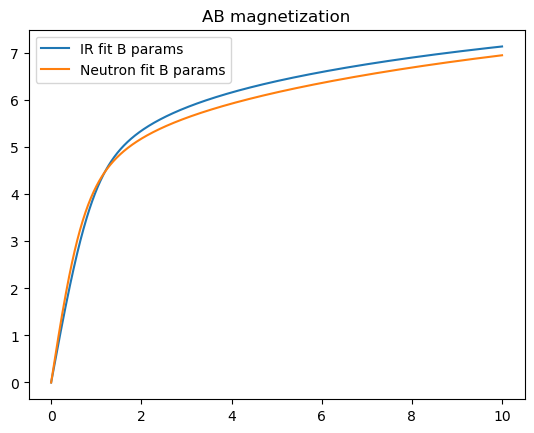

In [441]:
mme = magMe[0]
mAllen = magAllen[0]


Jperp = -0.2e-3 #meV
Jz = -2.4e-3 #meV
q= 6

# define lamb for CES
lambAB = Jperp
lambC = Jz
 
maxi = 10

mft_mZ_me = MolecularFieldTheory(f, ffine, -mme, lambAB*4.5)
mft_mZ_Allen = MolecularFieldTheory(f, ffine, -mAllen, lambAB)
plt.plot(f, 1*mft_mZ_me, label = 'IR fit B params')
plt.plot(f, 1*mft_mZ_Allen, label = 'Neutron fit B params')
# plt.xlim(0,10)
# plt.ylim(0,9)
plt.legend()
plt.title('AB magnetization')

# yee haw, lets load the data

In [442]:
Na = 6.02214076e23 
SCF = 1/(1.07828221e24/Na)
# import susceptibility
RawMTdata = np.genfromtxt('/Users/hopeless/Desktop/LeeLab/data/CsErSe2_data/CsErSe2_MTall.dat', 
                       delimiter='\t', unpack=True, skip_header=1)
## Take some averages because it is TOO many data points
CESMTdata = []
for i in range(len(RawMTdata)):
    CESMTdata.append(np.mean(RawMTdata[i].reshape(-1,5), axis=1))

In [443]:
### Import magnetization

CESMHdata = np.genfromtxt('/Users/hopeless/Desktop/LeeLab/data/CsErSe2_data/CsErSe2_MHall.dat', 
                       delimiter='\t', unpack=True, skip_header=1)

Text(0, 0.5, 'Magnetization (uB/Er)')

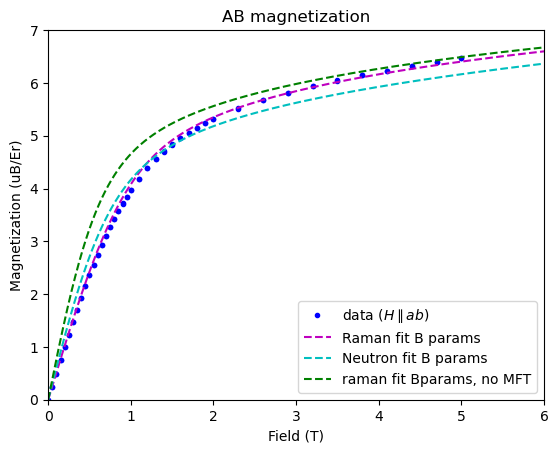

In [444]:
plt.plot(CESMHdata[0]/1e4,CESMHdata[1], 'b.', label='data ($H \\parallel ab$)')
plt.plot(f, mft_mZ_me, '--m', label = 'Raman fit B params')
plt.plot(f, mft_mZ_Allen, '--c',label = 'Neutron fit B params')
plt.plot(ffine, -1*mme, '--g', label = 'raman fit Bparams, no MFT')
plt.xlim(0,6)
plt.ylim(0,7)
plt.legend()
plt.title('AB magnetization')
plt.xlabel('Field (T)')
plt.ylabel('Magnetization (uB/Er)')
# plt.plot(CESMHdata[6]/1e4,CESMHdata[7],label='data ($H \\parallel c$)')

In [445]:
# plt.plot(CESMHdata[6]/1e4,CESMHdata[7],'b.', label='data ($H \\parallel c$)')
# plt.plot(f, mft_mZ_me_C, '-m', label = 'Raman fit B params')
# plt.plot(f, mft_mZ_Allen_C, '-c',label = 'Neutron fit B params')
# plt.plot(ffine, -1*mme_C, '--g', label = 'Raman fit Bparams, no MFT')
# plt.plot(ffine, -1*mAllen_C, '--', label = 'neutron fit Bparams, no MFT')
# # plt.xlim(0,4)
# # plt.ylim(0,7.6)
# plt.legend()
# plt.title('C magnetization')
# plt.xlabel('Field (T)')
# plt.ylabel('Magnetization (uB/Er)')
len(f)

1000

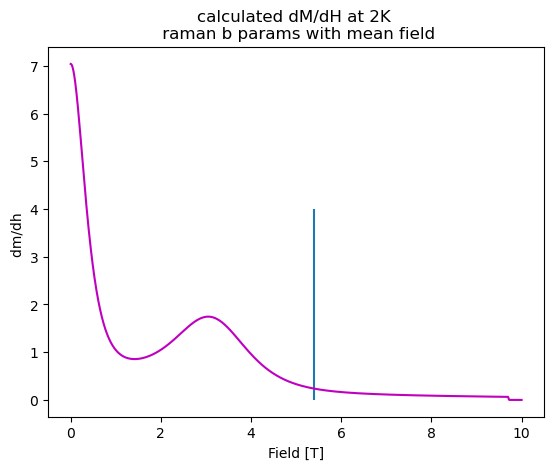

In [446]:
plt.title('calculated dM/dH at 2K \n raman b params with mean field')
plt.xlabel('Field [T]')
plt.ylabel('dm/dh ')
plt.vlines(5.4, 0, 4)
plt.plot(f, np.gradient(mft_mZ_me_C,f), '-m', label = 'Raman fit B params')

In [580]:



tempFine = np.linspace(0,10,10000)
tempF = np.linspace(0,10, 1000)

temps = [0.025, 0.045,0.1, 0.171, .25, .35, .45, .543, .827, 2, 6, 20]
n = len(temps)
colors = plt.cm.jet(np.linspace(0,1,n))

field = [[0,0,b] for b in tempFine]
m = []
tempMag = []

for temperature in temps: 
    magMe = np.array([MyErObj.magnetization(ion, temperature, f) for f in field]).T
    tempMag.append(magMe[2])
    temp = MolecularFieldTheory(tempF, tempFine, -magMe[2], lambC*-0.2)
    m.append(temp) # what the actual fuck is this naming holy shit


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Magnetization')

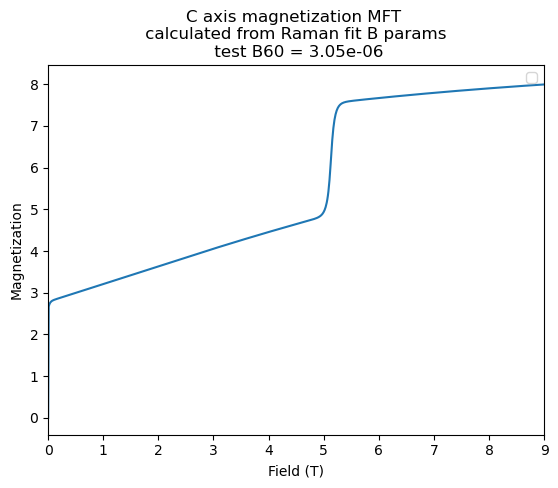

In [570]:
plt.figure()

# for i in range(1, len(m)): 
#     plt.plot(f, m[i], label = str(temps[i])+'K', color = colors[i])
plt.plot(f, m)
plt.legend()
# plt.ylim(0,3)
plt.xlim(0,9)
plt.title('C axis magnetization MFT \n calculated from Raman fit B params \n test B60 = '+str(B60))
plt.xlabel('Field (T)')
plt.ylabel('Magnetization')
# plt.ylim(0,3)

# real quick lets do a couple temps 

In [581]:
n = len(temps)
colors = plt.cm.jet(np.linspace(0,1,n))
i = 0

# calculate gradient
# dmdH = []
# # for mag in m: 
temp = np.gradient(temp)
# dmdH.append(temp)
# m = m.tolist()

Text(0.5, 1.0, 'C axis dM/dH \n calculated from Raman fit B params')

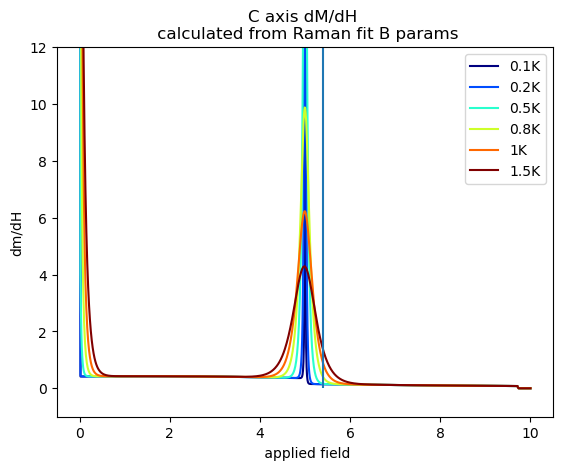

In [562]:
for i in range(len(temps)): 
    plt.plot(f, dmdH[i], label = str(temps[i])+'K', color = colors[i])

plt.legend()
plt.xlabel(' applied field')
plt.ylabel('dm/dH')
plt.vlines(x = 5.4, ymin=0, ymax = 12)
# plt.xlim(0,7)
plt.ylim(-1,12)
plt.title('C axis dM/dH \n calculated from Raman fit B params')

# now susceptibility

In [463]:
def susceptibility(ionObj, fieldVal, temps):
    chi = []
    for temp in temps: 
        f = np.linspace(fieldVal-0.1, 0.1+fieldVal, 100) 
        field = [[0,0,b] for b in f]
        mag= np.array([ionObj.magnetization(ion, temp, f) for f in field]).T
        m = MolecularFieldTheory(f, f, mag[2], Jz)
        m = np.array(m).T
        x = np.gradient(m, f) 
        # now we've gotta access the very low field value
        valIdx = findIdx(field, [0,0,fieldVal])
        chi.append(x[valIdx])
    return chi
def findIdx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [464]:
fieldVal = .1
df = 0.001
temps = np.linspace(1,200, 75)
mysus = susceptibility(MyErObj, fieldVal, temps) #myErObj.susceptibility(ion, temps, field, df)
# sus = ErObj.susceptibility(ion, temps, field, df)
neutronSus = susceptibility(AllenErObj, fieldVal, temps)

In [473]:
field = [0,0,.1]
susPCF = MyErObj.susceptibility(ion, temps, field, df)
susPCF = np.array(susPCF).T[2]
len(susPCF)

75

(0.0, 10.0)

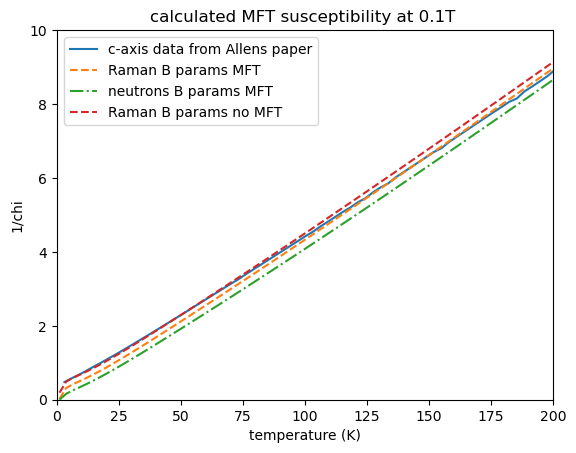

In [480]:
myinv = [-1/x for x in mysus]
neutroninv = [-1/x for x in neutronSus]
# sus =  [ErObj.susceptibility(ion, t, field, df) for t in temps]
susinvPCF = [-1/x for x in susPCF]
plt.plot(CESMTdata[12], 1/CESMTdata[13]*SCF, label='c-axis data from Allens paper')
plt.plot(temps, myinv, '--', label = 'Raman B params MFT')
plt.plot(temps, neutroninv, '-.', label = 'neutrons B params MFT' )
plt.plot(temps, susinvPCF, '--', label = 'Raman B params no MFT')
plt.title('calculated MFT susceptibility at 0.1T ')
plt.xlabel('temperature (K)')
plt.ylabel('1/chi')
plt.legend()
plt.xlim(0, 200)
plt.ylim(0,10)

In [481]:
fieldVal = .1
df = 0.001
temps = np.linspace(.001,2, 100)
mysus = susceptibility(MyErObj, fieldVal, temps) #myErObj.susceptibility(ion, temps, field, df)
# sus = ErObj.susceptibility(ion, temps, field, df)
neutronSus = susceptibility(AllenErObj, fieldVal, temps)

In [482]:
field = [0,0,.1]
susPCF = MyErObj.susceptibility(ion, temps, field, df)
susPCF = np.array(susPCF).T[2]
len(susPCF)

100

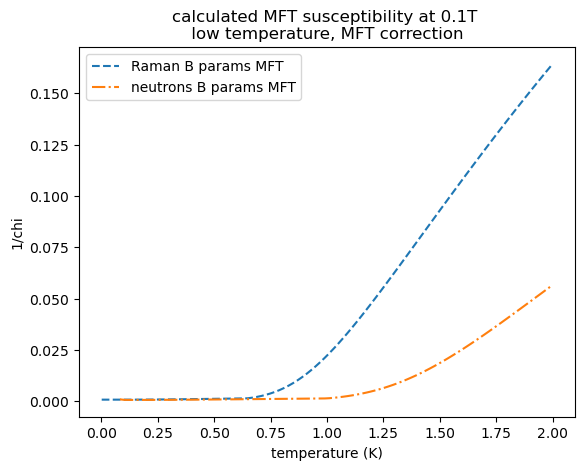

In [486]:
myinv = [-1/x for x in mysus]
neutroninv = [-1/x for x in neutronSus]
# sus =  [ErObj.susceptibility(ion, t, field, df) for t in temps]
susinvPCF = [-1/x for x in susPCF]
# plt.plot(CESMTdata[12], 1/CESMTdata[13]*SCF, label='c-axis data from Allens paper')
plt.plot(temps, myinv, '--', label = 'Raman B params MFT')
plt.plot(temps, neutroninv, '-.', label = 'neutrons B params MFT' )
# plt.plot(temps, susinvPCF, '--', label = 'Raman B params no MFT')
plt.title('calculated MFT susceptibility at 0.1T \n low temperature, MFT correction ')
plt.xlabel('temperature (K)')
plt.ylabel('1/chi')
plt.legend()
# plt.xlim(0, 200)
# plt.ylim(0,1)

In [491]:
field = [0,0,.1]
susPCFallen = AllenErObj.susceptibility(ion, temps, field, df)
susPCFallen = np.array(susPCFallen).T[2]

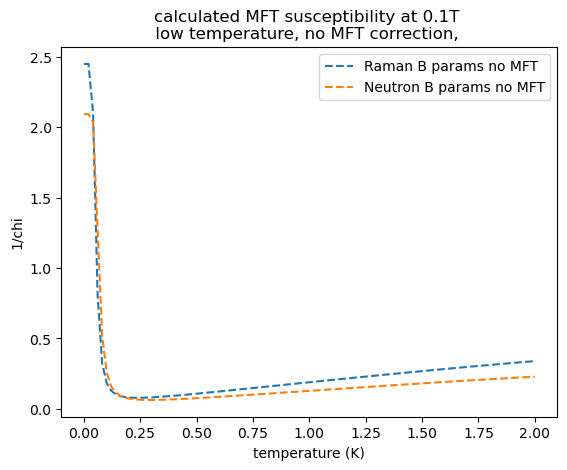

In [493]:
myinv = [-1/x for x in mysus]
neutroninv = [-1/x for x in neutronSus]
# sus =  [ErObj.susceptibility(ion, t, field, df) for t in temps]
susinvPCF = [-1/x for x in susPCF]
susinvPCFallen = [-1/x for x in susPCFallen]
# plt.plot(CESMTdata[12], 1/CESMTdata[13]*SCF, label='c-axis data from Allens paper')
# plt.plot(temps, myinv, '--', label = 'Raman B params MFT')
# plt.plot(temps, neutroninv, '-.', label = 'neutrons B params MFT' )
plt.plot(temps, susinvPCF, '--', label = 'Raman B params no MFT')
plt.plot(temps, susinvPCFallen, '--', label = 'Neutron B params no MFT')
plt.title('calculated MFT susceptibility at 0.1T \n low temperature, no MFT correction,  ')
plt.xlabel('temperature (K)')
plt.ylabel('1/chi')
plt.legend()